<a href="https://colab.research.google.com/github/whitechocobread/Ai-project/blob/main/1%EC%A3%BC%EC%B0%A8/speech_command_classification_with_torchaudio_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Speech Command Classification with torchaudio

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [5]:
print(torch.__version__)
!python -V

2.1.0+cu118
Python 3.8.6


스트리밍 출력 내용이 길어서 > /dev/null 2>&1을 사용하여 출력 값을 숨김

In [4]:
#파이썬 버전 변경 3.10.12 -> 3.8.6
#ERROR: Could not find a version that satisfies the requirement torch==1.7.0+cpu (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2)
#ERROR: No matching distribution found for torch==1.7.0+cpu 해결
!wget https://www.python.org/ftp/python/3.8.6/Python-3.8.6.tgz > /dev/null 2>&1
!tar xvfz Python-3.8.6.tgz > /dev/null 2>&1
!Python-3.8.6/configure > /dev/null 2>&1
!make > /dev/null 2>&1
!sudo make install > /dev/null 2>&1


In [6]:
#ERROR: command errored out with exit status 1 python setup.py egg_info 해결
!pip install --upgrade setuptools

     |████████████████████████████████| 807 kB 3.2 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 49.2.1
    Uninstalling setuptools-49.2.1:
      Successfully uninstalled setuptools-49.2.1


In [7]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
     |████████████████████████████████| 735.3 MB 24 kB/s 
     |████████████████████████████████| 12.8 MB 84.4 MB/s 
     |████████████████████████████████| 7.6 MB 2.8 MB/s 
     |████████████████████████████████| 17.3 MB 69.8 MB/s 
     |████████████████████████████████| 840 kB 73.7 MB/s 
     |████████████████████████████████| 3.5 MB 76.2 MB/s 
Using legacy 'setup.py install' for future, since package 'wheel' is not installed.
    Running setup.py install for future ... done


Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [9]:
# SpeechCommands 데이터세트 가져오기
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

100%|██████████| 2.26G/2.26G [01:47<00:00, 22.7MB/s]


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


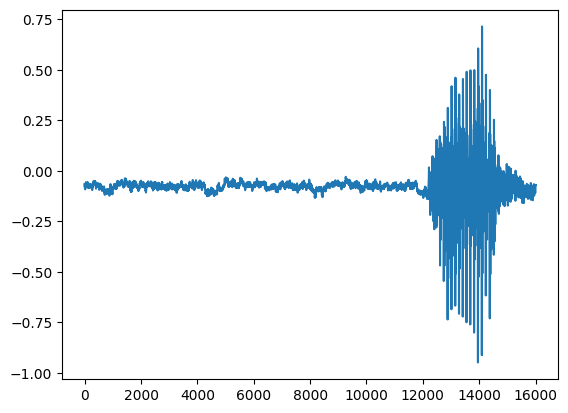

In [10]:
#웨이브폼 (waveform):시간에 따른 오디오 신호의 변화를 표현하는 시각적인 그래픽
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [11]:
import pandas as pd

# 주어진 라벨 리스트
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

# 데이터 프레임으로 변환
labels_df = pd.DataFrame({'Labels': labels})

# 데이터 프레임 출력
print(labels_df)


      Labels
0   backward
1        bed
2       bird
3        cat
4        dog
5       down
6      eight
7       five
8     follow
9    forward
10      four
11        go
12     happy
13     house
14     learn
15      left
16    marvin
17      nine
18        no
19       off
20        on
21       one
22     right
23     seven
24    sheila
25       six
26      stop
27     three
28      tree
29       two
30        up
31    visual
32       wow
33       yes
34      zero


The 35 audio labels are commands that are said by users. The first few
files are people saying “backward”.




In [12]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “zero”.




In [13]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data(전처리)

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [14]:
#transform 객체를 사용하여 데이터를 새로운 샘플 속도로 다시 샘플링함
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

We are encoding each word using its index in the list of labels.




In [15]:
#레이블 목록의 인덱스를 사용하여 각 단어를 인코딩
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [16]:
#리샘플링과 텍스트 인코딩
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [17]:
#M5 네트워크 아키텍처 모델
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [18]:
# Adam 최적화
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [19]:
#train 함수가 각 에포크에서의 훈련 손실의 평균을 반환하도록 변수
def train(model, epoch, log_interval):
    model.train()
    total_loss = 0  # 훈련 중 누적된 손실을 추적하기 위한 변수

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        data = transform(data)
        output = model(data)

        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        pbar.update(pbar_update)
        losses.append(loss.item())

    # 훈련 중 누적된 손실의 평균을 반환
    return total_loss / len(train_loader)



Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [20]:
#테스트 기능: 네트워크 정확도를 테스트하기 위한 기능
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




  0%|          | 0.0026666666666666666/2 [00:08<1:48:51, 3269.99s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.772120


  3%|▎         | 0.05599999999999999/2 [00:25<10:26, 322.23s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.269004


  5%|▌         | 0.10933333333333328/2 [00:42<10:03, 319.23s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.717819


  8%|▊         | 0.16266666666666676/2 [00:59<09:40, 316.04s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.253547


 11%|█         | 0.21600000000000033/2 [01:16<09:41, 326.07s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.048482


 13%|█▎        | 0.2693333333333337/2 [01:33<09:11, 318.62s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.998345


 16%|█▌        | 0.3226666666666667/2 [01:49<08:53, 318.10s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.909203


 19%|█▉        | 0.3759999999999997/2 [02:06<08:45, 323.70s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.749094


 21%|██▏       | 0.42933333333333273/2 [02:23<08:21, 319.20s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.640182


 24%|██▍       | 0.48266666666666574/2 [02:40<08:08, 321.88s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.662261


 27%|██▋       | 0.5359999999999995/2 [02:57<07:46, 318.55s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.470715


 29%|██▉       | 0.5893333333333336/2 [03:14<07:21, 313.04s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.384359


 32%|███▏      | 0.6426666666666677/2 [03:30<07:06, 313.87s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.449847


 35%|███▍      | 0.6960000000000018/2 [03:47<06:49, 314.08s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.203965


 37%|███▋      | 0.749333333333336/2 [04:04<06:34, 315.33s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.390738


 40%|████      | 0.8026666666666701/2 [04:20<06:10, 309.67s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.269941


 43%|████▎     | 0.8560000000000042/2 [04:37<05:57, 312.87s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.150370


 50%|█████     | 1.0000000000000062/2 [05:22<05:16, 316.72s/it]


Test Epoch: 1	Accuracy: 6831/11005 (62%)



 50%|█████     | 1.0026666666666728/2 [05:23<05:16, 317.57s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.959713


 53%|█████▎    | 1.0560000000000047/2 [05:39<05:03, 321.66s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.060561


 55%|█████▌    | 1.1093333333333366/2 [05:56<04:40, 314.59s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.997714


 58%|█████▊    | 1.1626666666666685/2 [06:13<04:22, 313.14s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.025527


 61%|██████    | 1.2160000000000004/2 [06:29<04:03, 310.36s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.057607


 63%|██████▎   | 1.2693333333333323/2 [06:46<03:44, 307.20s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.179126


 66%|██████▌   | 1.3226666666666642/2 [07:02<03:32, 313.51s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.995981


 69%|██████▉   | 1.3759999999999961/2 [07:19<03:17, 316.66s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 1.001066


 71%|███████▏  | 1.429333333333328/2 [07:36<02:58, 312.19s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.937476


 74%|███████▍  | 1.48266666666666/2 [07:53<02:39, 308.12s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.816189


 77%|███████▋  | 1.5359999999999918/2 [08:09<02:23, 309.47s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.989004


 79%|███████▉  | 1.5893333333333237/2 [08:26<02:09, 316.04s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 1.053219


 82%|████████▏ | 1.6426666666666556/2 [08:43<01:52, 314.16s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.816089


 85%|████████▍ | 1.6959999999999875/2 [09:00<01:33, 306.34s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.855492


 87%|████████▋ | 1.7493333333333194/2 [09:16<01:18, 311.82s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.928128


 90%|█████████ | 1.8026666666666513/2 [09:33<01:01, 311.13s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.755065


 93%|█████████▎| 1.8559999999999832/2 [09:50<00:45, 314.61s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.955578


100%|█████████▉| 1.9999999999999793/2 [10:34<00:00, 317.28s/it]



Test Epoch: 2	Accuracy: 7960/11005 (72%)



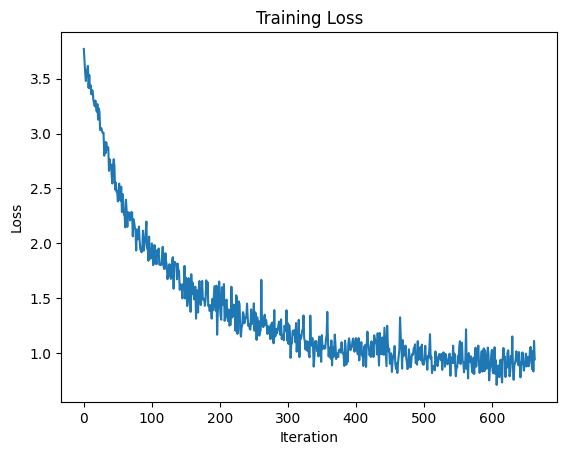

In [21]:
#2에포크일 경우
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iterations.
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()  # Display the plot


# **데이터 분석 및 모델 성능 평가**(2epoch)

Train Epoch: 0 [0/84843 (0%)]	Loss: 0.954806
Train Epoch: 0 [5120/84843 (6%)]	Loss: 0.877572
Train Epoch: 0 [10240/84843 (12%)]	Loss: 0.873816
Train Epoch: 0 [15360/84843 (18%)]	Loss: 0.809548
Train Epoch: 0 [20480/84843 (24%)]	Loss: 0.885156
Train Epoch: 0 [25600/84843 (30%)]	Loss: 0.750026
Train Epoch: 0 [30720/84843 (36%)]	Loss: 0.718751
Train Epoch: 0 [35840/84843 (42%)]	Loss: 0.811121
Train Epoch: 0 [40960/84843 (48%)]	Loss: 0.852620
Train Epoch: 0 [46080/84843 (54%)]	Loss: 0.883786
Train Epoch: 0 [51200/84843 (60%)]	Loss: 0.823366
Train Epoch: 0 [56320/84843 (66%)]	Loss: 0.756342
Train Epoch: 0 [61440/84843 (72%)]	Loss: 0.787217
Train Epoch: 0 [66560/84843 (78%)]	Loss: 0.641791
Train Epoch: 0 [71680/84843 (84%)]	Loss: 0.593100
Train Epoch: 0 [76800/84843 (90%)]	Loss: 0.903453
Train Epoch: 0 [81920/84843 (96%)]	Loss: 0.733370

Test Epoch: 0	Accuracy: 8068/11005 (73%)

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.693471
Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.667961
Train Epoch: 1 [10240

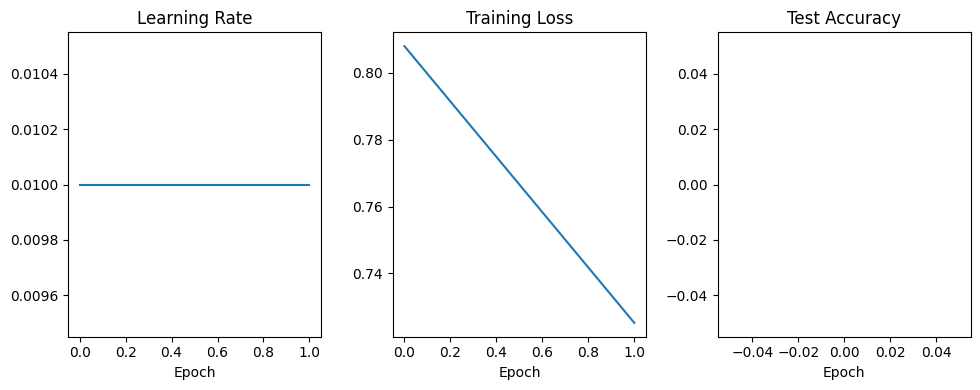

In [22]:
import matplotlib.pyplot as plt

learning_rates = []  # 학습률 저장 리스트
training_losses = []  # 훈련 손실 저장 리스트
test_accuracies = []  # 테스트 정확도 저장 리스트

# 훈련 루프 내부:
for epoch in range(2):
    # 여기에 훈련 코드를 작성합니다.
    train_loss = train(model, epoch, log_interval)  # 훈련 손실을 얻는 방법
    current_lr = optimizer.param_groups[0]['lr']  # 학습률을 얻는 방법

    # 각 목록에 값들을 추가합니다.
    learning_rates.append(current_lr)
    training_losses.append(train_loss)

    # 여기에 테스트 코드를 작성합니다.
    test_accuracy = test(model, epoch)  # 테스트 정확도를 얻는 방법의 예시
    test_accuracies.append(test_accuracy)

# Plot learning rate
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(learning_rates)
plt.title("Learning Rate")
plt.xlabel("Epoch")

# Plot training loss
plt.subplot(1, 3, 2)
plt.plot(training_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()


# **Early Stopping**

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.690555
Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.651170
Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.702488
Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.611647
Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.689110
Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.585119
Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.613899
Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.554968
Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.727414
Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.669695
Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.691935
Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.713034
Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.653106
Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.718890
Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.649557
Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.736236
Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.580697

Test Epoch: 1	Accuracy: 8404/11005 (76%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.568565
Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.456861
Train Epoch: 2 [10240

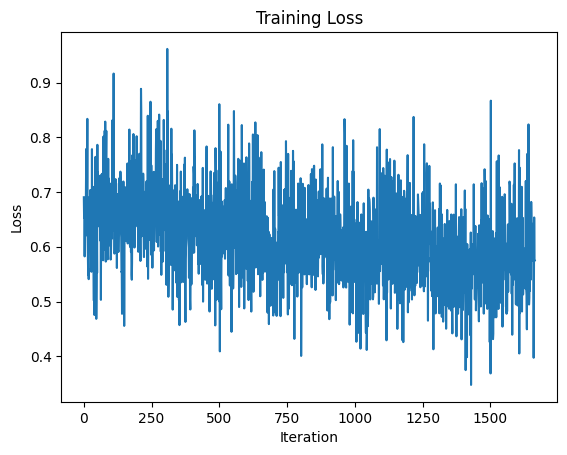

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

log_interval = 20
n_epoch = 21

patience = 5
best_val_loss = np.inf
counter = 0
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

transform = transform.to(device)

for epoch in range(1, n_epoch + 1):
    train_loss = train(model, epoch, log_interval)
    losses.append(train_loss)
    val_loss = test(model, epoch)

    if val_loss is not None and val_loss < best_val_loss:  # Check if val_loss is not None
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping after {epoch} epochs.")
        break

    scheduler.step()

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


# **데이터 분석 및 모델 성능 평가(early stopping)**

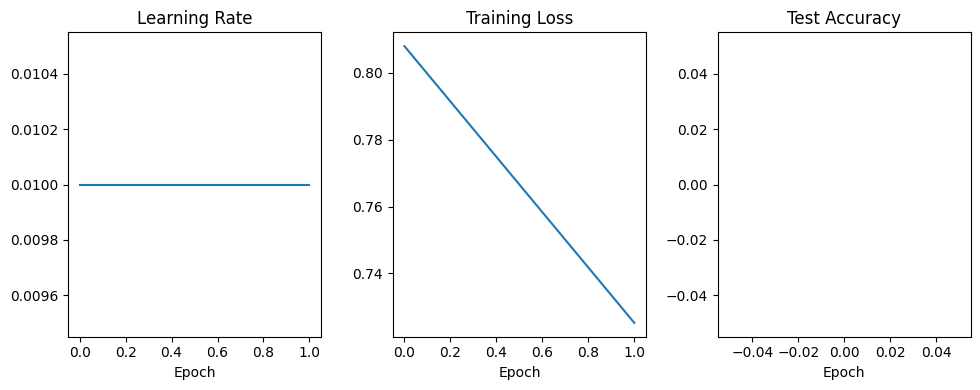

In [24]:
import matplotlib.pyplot as plt

# Plot learning rate
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(learning_rates)
plt.title("Learning Rate")
plt.xlabel("Epoch")

# Plot training loss
plt.subplot(1, 3, 2)
plt.plot(training_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()

The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [25]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [26]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: nine.


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




In [27]:
import sys
sys.path


['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython']

In [28]:
#ModuleNotFoundError: No module named 'pydub'문제 해결
#"pydub" 패키지의 경로가 경로 리스트에 없어서, 필요한 경로를 직접 추가
sys.path.append('/usr/local/lib/python3.8/site-packages')

In [29]:
def record(seconds=3):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 3 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: go.


In [30]:
ipd.Audio(transformed.numpy(), rate=new_sample_rate)

## Conclusion

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


